In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 100,
})

from Finite_volume_method_1D import *

In [2]:
chippath = '../../DataKian/bTa_LT278W2chip5/'
filename = 'KID5_103dBm__TmK20_avgpulse_ampphase.csv'
length = 90

lambdanm = 402
KID402 = KID_data(chippath,lambdanm,filename,length)

lambdanm = 673
KID673 = KID_data(chippath,lambdanm,filename,length)

lambdanm = 986
KID986 = KID_data(chippath,lambdanm,filename,length)

lambdanm = 1545
KID1545 = KID_data(chippath,lambdanm,filename,length)

In [3]:
KID402.fit_tail(start=150,end=250,showplots=False)
KID673.fit_tail(start=150,end=250,showplots=False)
KID986.fit_tail(start=150,end=250,showplots=False)
KID1545.fit_tail(start=130,end=230,showplots=False)

KIDdict = {
    402 : KID402,
    673 : KID673,
    986 : KID986,
    1545 : KID1545
}

In [4]:
print(KID402.tauqpstar,KID402.tauqpstarstd)
print(KID673.tauqpstar,KID673.tauqpstarstd)
print(KID986.tauqpstar,KID986.tauqpstarstd)
print(KID1545.tauqpstar,KID1545.tauqpstarstd)
print(KID402.L)
print(KID673.L)
print(KID986.L)
print(KID1545.L)

L=np.mean([KID402.L,KID673.L,KID986.L,KID1545.L])

64.47248733519922 4.86899916554073
58.248553397863745 4.300854595584184
67.3438194726096 6.939516763746381
62.03713253438946 11.676947426565471
0.015510492015003163
0.017167808325977668
0.014849172616452574
0.016119378171543686


In [5]:
simtime = 50
leeway = 0

FITx = np.arange(simtime-leeway)*KID402.dt
FITy = {}
for l in [402,673,986,1545]:
    indmin = np.argmax(KIDdict[l].phase)
    indmax = indmin + simtime - leeway
    FITy[l] = KIDdict[l].phase[indmin:indmax]

plotdatay = np.array([FITy[402],FITy[673],FITy[986],FITy[1545]])
fitdatay = plotdatay.ravel()

def func_to_parallelize(t,K,phi_init,l,KID,flag):
     SIM = KID_sim(KID,0.13,K,phi_init/l,0.05,1/4,sigma_IC=2,simtime_approx=simtime,D_const=flag)
     return np.interp(t,SIM.t_axis,SIM.timeseriestheta)
     
def fitfunc(t,K,IC,flag):
     datalist = Parallel(n_jobs=4)(delayed(func_to_parallelize)(t,K,IC,l,KIDdict[l],flag) for l in [402,673,986,1545])
     return np.concatenate(datalist)

100%|██████████| 1000/1000 [00:01<00:00, 809.08it/s]


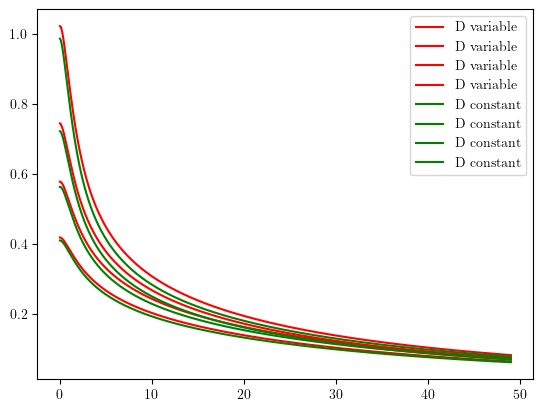

In [18]:
taxis = np.linspace(FITx[0],FITx[-1],1000)
plotfit = fitfunc(taxis,10,1000,False)
plotfit = np.reshape(plotfit,np.stack([taxis,taxis,taxis,taxis]).shape)
plt.figure()
for y,fit in zip(plotdatay,plotfit):
    plt.plot(taxis,fit,color='r',label='D variable')
plotfit = fitfunc(taxis,10,1000,True)
plotfit = np.reshape(plotfit,np.stack([taxis,taxis,taxis,taxis]).shape)
for y,fit in zip(plotdatay,plotfit):
    plt.plot(taxis,fit,color='g',label='D constant')
plt.legend()
plt.show()